In [1]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pkl
import pandas as pd
import os,sys,glob, h5py
from itertools import combinations, chain
import tqdm
import seaborn as sns
import pandas as pd
sns.set_style('white')
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

C:\Users\Kim\Anaconda3\envs\welle_lab\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# load data

In [4]:
df_= pd.read_json(r'Z:\BIOElectricsLab\Kim\NPX_recordings\MOBP_NPX_cohort7\df7_depth.json')
df_['timepoint'] = 2
df_ = df_[df_.group=='good']

# per smith & kohn 2008

In [36]:
# cross correlation normalized to geometric mean

def ccg(train1,train2,binrange,binsize,correction=False):
    diffs = []
    count=0
    if correction != False:
        if correction == 'jitter':
            train1 = jitter(train1,0.05)
            train2 = jitter(train2,0.05)
        else: 
            print('improper correction method specified')
            return np.nan
    if len(train1) > 1 and len(train2) > 1:
        for spiketime_train1 in train1:
            #for spiketime_train2 in train2:
            if train2[-1] > spiketime_train1 + binrange[0]: # if there are any spikes from train2 after the start of the window 
                start = np.where(train2 > spiketime_train1 + binrange[0])[0][0]

                if train2[-1] > spiketime_train1 + binrange[1]:#set the end of train2 to only relevant window around this spike
                    end = np.where(train2 > spiketime_train1 + binrange[1])[0][0]
                else:
                    end = len(train2)

                for spiketime_train2 in train2[start:end]:
                    diffs.extend([float(spiketime_train1) - float(spiketime_train2)])
                    count+=1
        diffs = np.array(diffs)*-1
        hist,edges = np.histogram(diffs,bins=int((binrange[1]-binrange[0])/binsize),range=binrange)
        return (hist / float(len(train1)))*100,edges
        #return (hist / float(len(train1)*len(train2) / 2.)  ,edges)
        #return ((hist / (len(train1) * len(train2)) / 2.)*100 * binsize,edges)
    else:
        print('input spiketrains not long enough: 1:'+str(len(train1))+' 2:'+str(len(train2)))
        return [0],[0,0]

In [20]:
# jitter per Smith and Kohn 2008
def jitter(train,binsize):
    start = np.min(train) - (binsize/2.)
    end = np.max(train) + binsize
    bin_left_edges = np.arange(start,end,binsize)
    to = [train[np.where((train < bin_left_edges[i+1]) & (train > bin_left_edges[i]))[0]] - bin_left_edges[i]  for i in range(len(bin_left_edges)-1)]
    all_to = np.concatenate(to).ravel()
    jittered = []
    spike_indices = np.arange(all_to.shape[0]).tolist()
    np.random.seed()
    np.random.shuffle(spike_indices)
    for i,bin_ in tqdm.tqdm(enumerate(to)):
        spikes = []
        for spike in bin_:
            spikes.extend([all_to[spike_indices.pop(0)]])
        jittered.append(np.array(spikes) + bin_left_edges[i])
    jittered = np.concatenate(jittered).ravel()
    return jittered

# create dataframe and run ccg

In [61]:
mid = 276

In [1]:
df = df_[df_.mouse==mid]
total_pairs = list(combinations(df.index,2))
num_pairs = np.arange(1,len(total_pairs)+1,1)
df_pairs = pd.DataFrame(index=num_pairs,
                        columns=['mouse','cohort','cell1','cell2','ind1','ind2','type1','type2'])

NameError: name 'df_' is not defined

In [67]:
start_ = 0
numpairs=len(list(combinations(df.cell,2)))
    
df_pairs['mouse'][start_:start_+numpairs]=mid
df_pairs['cohort']=[c[0] for c in list(combinations(df.cohort,2))]
df_pairs['cell1']=[c[0] for c in list(combinations(df.cell,2))]
df_pairs['cell2']=[c[1] for c in list(combinations(df.cell,2))]
df_pairs['ind1']=[c[0] for c in list(combinations(df.index,2))]
df_pairs['ind2']=[c[1] for c in list(combinations(df.index,2))]
df_pairs['type1']=[c[0] for c in list(combinations(df.waveform_class,2))]
df_pairs['type2']=[c[1] for c in list(combinations(df.waveform_class,2))]
    
start_+=numpairs

In [68]:
ccgs = []
for i in df_pairs.index:
    train1 = np.array(df.times[df_pairs.ind1[i]])
    train2 = np.array(df.times[df_pairs.ind2[i]])
    ccg_ = ccg(train1,train2,(-.5,.5),0.001) # 1 ms bins
    ccgs.append(ccg_)
df_pairs['ccg'] = hists

In [69]:
jitt_ccg = []
for i in df_pairs.index:
    train1 = np.array(df.times[df_pairs.ind1[i]]) # non-jittered spike train
    train2 = jitter(np.array(df_.times[df_pairs.ind2[i]]),0.05) # jittered spike train, jitter in 50 ms bins
    jit = ccg(train1,train2,(-.5,.5),0.001)
    jitt_ccg.append(jit)
df_pairs['jitter_ccg'] = jitt_ccg

78550it [00:00, 241844.32it/s]
79883it [00:00, 263284.17it/s]
78550it [00:00, 249103.15it/s]
78000it [00:00, 218173.04it/s]
78550it [00:00, 239661.79it/s]
79101it [00:00, 252701.56it/s]
78550it [00:00, 243817.17it/s]
80072it [00:00, 237743.40it/s]
78550it [00:00, 255788.96it/s]
80055it [00:00, 236745.37it/s]
78550it [00:00, 328812.19it/s]
80042it [00:00, 311318.70it/s]
78550it [00:00, 270733.90it/s]
79101it [00:00, 260451.38it/s]
78550it [00:00, 265709.13it/s]
78105it [00:00, 270664.54it/s]
78550it [00:00, 314436.30it/s]
80086it [00:00, 265185.39it/s]
78550it [00:00, 264028.84it/s]
78322it [00:00, 211489.54it/s]
78550it [00:00, 309459.43it/s]
56075it [00:00, 285800.59it/s]
78550it [00:00, 243659.75it/s]
61823it [00:00, 274898.34it/s]
78550it [00:00, 278828.68it/s]
80086it [00:00, 166811.28it/s]
78550it [00:00, 251462.45it/s]
78667it [00:00, 271001.98it/s]
78550it [00:00, 252596.85it/s]
80073it [00:00, 138030.42it/s]
78550it [00:00, 280561.78it/s]
79951it [00:00, 359474.65it/s]
78550it 

80072it [00:00, 245160.29it/s]
79893it [00:00, 255994.51it/s]
80072it [00:00, 187246.32it/s]
80086it [00:00, 180303.58it/s]
80072it [00:00, 195438.33it/s]
80007it [00:00, 263603.99it/s]
80072it [00:00, 226357.75it/s]
79662it [00:00, 243775.61it/s]
80072it [00:00, 234433.61it/s]
80049it [00:00, 211897.73it/s]
80072it [00:00, 226146.64it/s]
79924it [00:00, 195025.57it/s]
80072it [00:00, 263131.71it/s]
80066it [00:00, 250548.66it/s]
80072it [00:00, 254383.73it/s]
80079it [00:00, 205312.14it/s]
80072it [00:00, 238071.86it/s]
80076it [00:00, 167441.11it/s]
80072it [00:00, 220898.33it/s]
80085it [00:00, 180212.53it/s]
80072it [00:00, 172724.46it/s]
80060it [00:00, 228197.15it/s]
80072it [00:00, 295401.16it/s]
79482it [00:00, 197630.29it/s]
80072it [00:00, 280612.51it/s]
80081it [00:00, 244866.10it/s]
80072it [00:00, 192430.20it/s]
80084it [00:00, 332608.14it/s]
80072it [00:00, 236227.51it/s]
63267it [00:00, 299615.81it/s]
80072it [00:00, 173140.57it/s]
80075it [00:00, 142156.12it/s]
80072it 

80086it [00:00, 218121.57it/s]
79951it [00:00, 211769.43it/s]
80086it [00:00, 197803.78it/s]
80057it [00:00, 246121.02it/s]
80086it [00:00, 212711.21it/s]
80007it [00:00, 251669.56it/s]
80086it [00:00, 212032.88it/s]
79548it [00:00, 212160.51it/s]
80086it [00:00, 270427.50it/s]
80076it [00:00, 227434.10it/s]
80086it [00:00, 219409.11it/s]
79983it [00:00, 150667.06it/s]
80086it [00:00, 220043.96it/s]
79736it [00:01, 77830.24it/s]
80086it [00:00, 234872.34it/s]
78162it [00:00, 308318.91it/s]
80086it [00:00, 231658.00it/s]
80086it [00:00, 130456.31it/s]
80086it [00:00, 190339.38it/s]
80088it [00:00, 118853.13it/s]
80086it [00:00, 215492.82it/s]
76502it [00:00, 250447.35it/s]
80086it [00:00, 296964.65it/s]
79893it [00:00, 238077.18it/s]
80086it [00:00, 205200.26it/s]
80086it [00:00, 258974.56it/s]
80086it [00:00, 299834.62it/s]
80007it [00:00, 227891.83it/s]
80086it [00:00, 296239.46it/s]
79662it [00:00, 187290.41it/s]
80086it [00:00, 260861.45it/s]
80049it [00:00, 208484.59it/s]
80086it [

78667it [00:00, 238212.97it/s]
79662it [00:00, 246330.69it/s]
78667it [00:00, 239403.14it/s]
80049it [00:00, 232821.05it/s]
78667it [00:00, 245061.00it/s]
79924it [00:00, 223683.53it/s]
78667it [00:00, 293569.22it/s]
80066it [00:00, 216816.03it/s]
78667it [00:00, 285664.71it/s]
80079it [00:00, 202347.05it/s]
78667it [00:00, 233945.23it/s]
80076it [00:00, 187217.68it/s]
78667it [00:00, 311051.64it/s]
80085it [00:00, 168635.41it/s]
78667it [00:00, 212678.26it/s]
80060it [00:00, 279386.69it/s]
78667it [00:00, 296409.80it/s]
79482it [00:00, 159392.74it/s]
78667it [00:00, 268955.54it/s]
80081it [00:00, 285313.64it/s]
78667it [00:00, 292968.66it/s]
80084it [00:00, 196827.43it/s]
78667it [00:00, 274972.55it/s]
63267it [00:00, 277424.85it/s]
78667it [00:00, 302263.28it/s]
80075it [00:00, 151707.51it/s]
78667it [00:00, 319811.76it/s]
80072it [00:00, 253959.97it/s]
78667it [00:00, 266311.52it/s]
77503it [00:00, 277164.39it/s]
78667it [00:00, 216013.38it/s]
79056it [00:00, 216190.02it/s]
78667it 

80076it [00:00, 156684.93it/s]
79893it [00:00, 236615.63it/s]
80076it [00:00, 183520.31it/s]
80086it [00:00, 169087.69it/s]
80076it [00:00, 163939.37it/s]
80007it [00:00, 203370.96it/s]
80076it [00:00, 144228.83it/s]
79662it [00:00, 155462.41it/s]
80076it [00:00, 146588.16it/s]
80049it [00:00, 175297.18it/s]
80076it [00:00, 138519.78it/s]
79924it [00:00, 161878.71it/s]
80076it [00:00, 177026.92it/s]
80066it [00:00, 196121.35it/s]
80076it [00:00, 206102.94it/s]
80079it [00:00, 210281.61it/s]
80076it [00:00, 175195.32it/s]
80076it [00:00, 172095.39it/s]
80076it [00:00, 218289.09it/s]
80085it [00:00, 152124.18it/s]
80076it [00:00, 176129.12it/s]
80060it [00:00, 256031.82it/s]
80076it [00:00, 196373.27it/s]
79482it [00:00, 186374.01it/s]
80076it [00:00, 202264.17it/s]
80081it [00:00, 187639.27it/s]
80076it [00:00, 188720.10it/s]
80084it [00:00, 216118.41it/s]
80076it [00:00, 183217.87it/s]
63267it [00:00, 203533.78it/s]
80076it [00:00, 171836.62it/s]
80075it [00:00, 138441.19it/s]
80076it 

76502it [00:00, 247245.43it/s]
79958it [00:00, 337748.95it/s]
76502it [00:00, 275383.67it/s]
79670it [00:00, 297491.41it/s]
76502it [00:00, 225923.06it/s]
80076it [00:00, 166839.41it/s]
79893it [00:00, 259916.50it/s]
80086it [00:00, 225895.50it/s]
79893it [00:00, 211276.51it/s]
80007it [00:00, 205834.53it/s]
79893it [00:00, 221847.78it/s]
79662it [00:00, 257428.22it/s]
79893it [00:00, 194320.24it/s]
80049it [00:00, 195938.96it/s]
79893it [00:00, 232007.11it/s]
79924it [00:00, 268398.17it/s]
79893it [00:00, 244347.90it/s]
80066it [00:00, 209366.37it/s]
79893it [00:00, 217184.11it/s]
80079it [00:00, 233417.03it/s]
79893it [00:00, 229612.63it/s]
80076it [00:00, 166484.05it/s]
79893it [00:00, 254907.49it/s]
80085it [00:00, 192909.54it/s]
79893it [00:00, 222286.92it/s]
80060it [00:00, 269190.24it/s]
79893it [00:00, 248877.05it/s]
79482it [00:00, 147322.11it/s]
79893it [00:00, 207519.56it/s]
80081it [00:00, 264291.67it/s]
79893it [00:00, 193623.08it/s]
80084it [00:00, 235361.17it/s]
79893it 

80076it [00:00, 176735.16it/s]
79056it [00:00, 217917.00it/s]
80076it [00:00, 193527.94it/s]
64222it [00:00, 205528.75it/s]
80076it [00:00, 184520.39it/s]
80083it [00:00, 248513.95it/s]
80076it [00:00, 189425.35it/s]
79167it [00:00, 270664.11it/s]
80076it [00:00, 176108.43it/s]
80061it [00:00, 242097.01it/s]
80076it [00:00, 192598.94it/s]
80065it [00:00, 248327.28it/s]
80076it [00:00, 165355.63it/s]
79605it [00:00, 231401.48it/s]
80076it [00:00, 165287.68it/s]
77327it [00:00, 239092.25it/s]
80076it [00:00, 181642.56it/s]
63653it [00:00, 261196.11it/s]
80076it [00:00, 176151.48it/s]
77534it [00:00, 247182.47it/s]
80076it [00:00, 172340.80it/s]
80059it [00:00, 263891.40it/s]
80076it [00:00, 175946.98it/s]
77293it [00:00, 238304.28it/s]
80076it [00:00, 180855.48it/s]
80085it [00:00, 257498.28it/s]
80076it [00:00, 175831.20it/s]
80088it [00:00, 124251.68it/s]
80076it [00:00, 180208.13it/s]
78563it [00:00, 277510.29it/s]
80076it [00:00, 177091.51it/s]
79958it [00:00, 254885.51it/s]
80076it 

79167it [00:00, 250307.16it/s]
80061it [00:00, 264130.69it/s]
79167it [00:00, 258234.82it/s]
80065it [00:00, 211281.64it/s]
79167it [00:00, 251847.78it/s]
79605it [00:00, 260737.42it/s]
79167it [00:00, 246202.21it/s]
77327it [00:00, 247362.61it/s]
79167it [00:00, 235127.42it/s]
63653it [00:00, 255366.72it/s]
79167it [00:00, 245326.73it/s]
77534it [00:00, 239406.67it/s]
79167it [00:00, 260891.93it/s]
80059it [00:00, 260358.61it/s]
79167it [00:00, 220676.55it/s]
77293it [00:00, 284688.90it/s]
79167it [00:00, 252473.96it/s]
80085it [00:00, 232282.75it/s]
79167it [00:00, 234067.81it/s]
80088it [00:00, 125326.99it/s]
79167it [00:00, 253394.52it/s]
78563it [00:00, 251235.03it/s]
79167it [00:00, 219979.35it/s]
79958it [00:00, 251492.99it/s]
79167it [00:00, 260648.02it/s]
79670it [00:00, 254061.48it/s]
79167it [00:00, 236417.30it/s]
80076it [00:00, 176379.50it/s]
80061it [00:00, 251238.18it/s]
80065it [00:00, 239276.70it/s]
80061it [00:00, 248024.35it/s]
79605it [00:00, 271042.34it/s]
80061it 

In [70]:
corr = []
for i in df_pairs.index:
    train1 = df_pairs.ccg[i]
    train2 = df_pairs.jitter_ccg[i]
    corrected = train1[0]-train2[0]
    corr.append(corrected)
df_pairs['corrected_ccg'] = corr

# classify positive cell pair peaks

In [8]:
def countlist(lst): #to count consecutive numbers in movement-related code
    streak_count = []
    counter = 1
    for i in range(len(lst)):
        if i != (len(lst) - 1):
            diff = lst[i+1] - lst[i]
            if diff == 1:
                counter += 1
            else:
                streak_count.append(counter)
                counter = 1
        else:
            streak_count.append(counter)
    return(streak_count)

In [ ]:
t = np.arange(-0.5,0.5,0.001)
positive_pair = []
consec_peak = []
consec_bins = []
for i,pair in enumerate(df_pairs.corrected_ccg):
    mn = np.mean(pair)
    std = np.std(pair)
    cntr = pair[480:520] # look for peak within 40 ms of zero lag -- 40 ms == 40 bins, zero lag is 500th index
    mx = np.max(cntr)
    
    peak_thresh = (5*std) + mn
    if mx > peak_thresh:
        positive_pair.append('yes')
    else:
        positive_pair.append('no')
    
    lower_thresh = (2*std) + mn
    cross_peak = np.where(pair[480:520]>peak_thresh)[0] # find where ccg crosses higher threshold
    cross_bins = np.where(pair[480:520]>lower_thresh)[0] # find where ccg crosses lower threshold
    consec_peak.append(countlist(cross_peak)) # for how long does ccg cross the peak threshold
    consec_bins.append(countlist(cross_bins)) # for how long does the ccg cross the lower threshold

# example peaks

In [10]:
df_peaks = pd.read_json(r'C:\Users\Kim\Documents\Data\kimdata\cellpairs\df_PosPairs5454_r2.json')

In [13]:
df_peaks = df_peaks[df_peaks.positive_pairs_r2=='common_input']

In [14]:
df_peaks = df_peaks.reset_index()

In [58]:
train1 = np.array(df[df.cell==29].times[928])
train2 = np.array(df[df.cell==61].times[939])

In [59]:
ccg_ = ccg(train1,train2,(-.5,.5),0.001)

(400.0, 600.0)

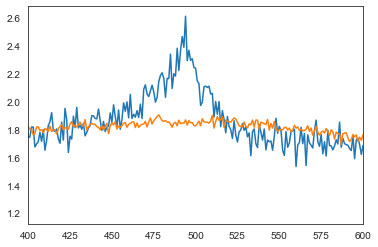

In [81]:
plt.plot(ccg_[0])
plt.plot(jit)
plt.xlim(400,600)